# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [87]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [110]:
import math
import copy

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def vscale(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv[:,:,2]
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

last_frame_lines = []
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # The threshold used on X axis limit when filtering out noise lines
    x_limit_threshold = 30
    
    # The number of last frames used to help determine left & right lanes on this frames  
    num_of_buf_frames = 9
    
    global last_frame_lines
    
    # Get image size
    x_size = img.shape[1]
    y_size = img.shape[0]

    # Helpful params
    left_line_segments = []
    right_line_segments = []

    avg_left_slope = 0
    avg_right_slope = 0

    avg_left_x = 0
    avg_right_x = 0      
    
    new_lines = copy.copy(lines)
    for frame_lines in last_frame_lines :
        lines = np.concatenate((lines, frame_lines))

    # Only buf the number of frames set in num_of_buf_frames, pop the last one if it will have more than the limit.
    if len(last_frame_lines) >= buf_frame_num :
        last_frame_lines.pop(0)
    
    last_frame_lines.append(new_lines)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # Calculate slope and x_pos of each line
            slope = (y2-y1)/(x2-x1)
            x_pos = (y_size-y1+slope*x1)/slope

            '''
            Implement a simple average slope and average x pos cacluation
            '''
            # Caculate avg left slope and avg x pos
            if x_pos < x_size/2 - 40 and x_pos >x_limit_threshold and slope < -0.3 and slope > -7 and x1 < x_size/2 and x2 < x_size/2:
                left_line_segments.append(line)
                avg_left_slope = (avg_left_slope*(len(left_line_segments)-1)+slope)/len(left_line_segments)
                avg_left_x = (avg_left_x*(len(left_line_segments)-1)+x_pos)/len(left_line_segments)
            
            # Caculate avg right slope and avg y pos
            if x_pos > x_size/2 + 40 and x_pos <x_size-x_limit_threshold and slope > 0.3 and slope < 7 and x1 > x_size/2 and x2 > x_size/2:
                right_line_segments.append(line)
                avg_right_slope = (avg_right_slope*(len(right_line_segments)-1)+slope)/len(right_line_segments)
                avg_right_x = (avg_right_x*(len(right_line_segments)-1)+x_pos)/len(right_line_segments)

    # Set a hardcoded lane length.
    right_end_y = left_end_y = y_size * 13 / 20
    overlay = np.copy(img)*0
        
    # Compose and draw left lane
    if avg_left_slope == 0 :
        point = [0, left_end_y]
    else :
        point = [avg_left_x - (y_size-left_end_y)/avg_left_slope, left_end_y]    
        
    cv2.line(overlay, (int(float(point[0])), int(point[1])), (int(float(avg_left_x)), y_size), color, thickness)

    # Compose and draw right lane
    if avg_right_slope == 0 :
        point = [0, right_end_y]
    else :
        point = [avg_right_x - (y_size-right_end_y)/avg_right_slope, right_end_y]
        
    cv2.line(overlay, (int(float(point[0])), int(point[1])), (int(float(avg_right_x)), y_size), color, thickness)
    
    return weighted_img(overlay, img)

def draw_lines2(img, lines, color=[255, 0, 0], thickness=2):
     for line in lines:
         for x1,y1,x2,y2 in line:
             cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline & Test Images



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

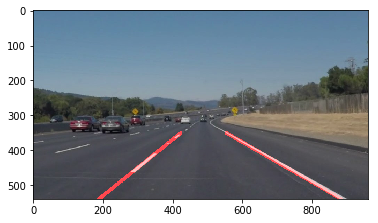

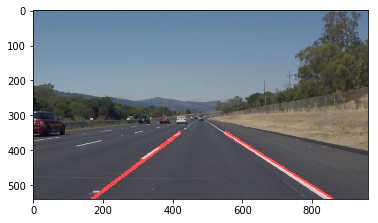

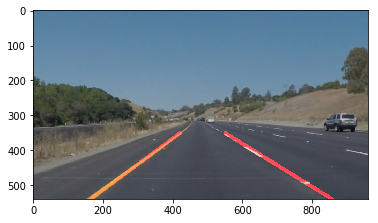

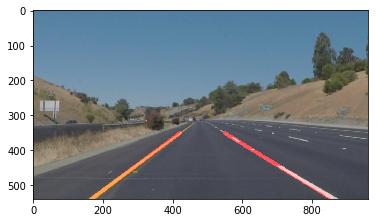

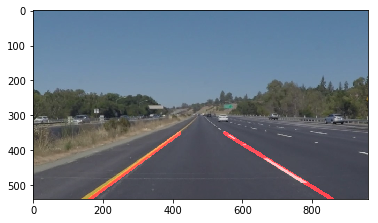

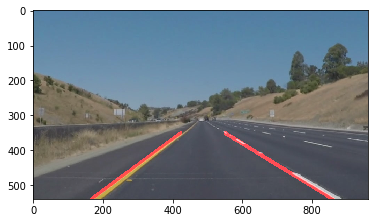

In [111]:
import os
list = os.listdir("test_images/")

for image_name in list :
    if 'with-lanes.' not in image_name :
        image = mpimg.imread("test_images/" + image_name)
        plt.imshow(process_image(image))
        plt.show()
    
        cv2.imwrite('test_images/%s-with-lanes.jpg' % image_name.split('.', 1)[0], image)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [96]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [97]:
def process_image(image):
    
    origin_image = image    

    # Transform image to HSV and only return channel V
    image = vscale(image)
    
    # Gaussian blur
    image = gaussian_blur(image, 9);

    # Canny
    low_threshold = 40
    high_threshold = 50
    edges = canny(image, low_threshold, high_threshold)

    # Mask of image
    imshape = image.shape
    
    # Calculate mask ratio and vertices
    x_ratio = 450/960 
    y_ratio = 320/540
    
    vertices = np.array([[(50,imshape[0]),(x_ratio * imshape[1], y_ratio * imshape[0]), (imshape[1] - x_ratio * imshape[1], y_ratio * imshape[0]), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    
    # Get edges withing the region of interest
    edges = region_of_interest(edges, vertices);

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 35
    min_line_length = 35
    max_line_gap = 210 #15 

    # Hough Transform 
    lines = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw lines and return
    line_image = np.copy(origin_image)
    return draw_lines(line_image, lines)


Let's try the one with the solid white lane on the right first ...

In [92]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 57.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.14 s, sys: 861 ms, total: 5 s
Wall time: 4.29 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Try 'yellow.mp4'

In [112]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 51.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 14.4 s, sys: 2.27 s, total: 16.7 s
Wall time: 14.1 s


In [113]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

## [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [114]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 19.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 11.6 s, sys: 1.74 s, total: 13.3 s
Wall time: 14.9 s


In [115]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))